# 过拟合

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Default parameters for plots
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['figure.figsize'] = [12, 10]
matplotlib.rcParams['font.family'] = ['Noto Sans CJK JP']
matplotlib.rcParams['axes.unicode_minus']=False 
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)
    

## 1 模型容量
通俗地讲，模型的容量或表达能力，是指模型**拟合复杂函数**的能力。一种体现模型容
量的指标为模型的假设空间(Hypothesis Space)大小，即模型可以表示的函数集的大小。假
设空间越大越完备，从假设空间中搜索出逼近真实模型的函数也就越有可能；反之，如果
假设空间非常受限，就很难从中找到逼近真实模型的函数。

函数的假设空间越大，就越有可能找到一个函数更好地逼近真实分布的函数模型. 但是过大的假设空间无疑会增加搜索难度和计算代价. 由于观测误差的存在，较大的假设空间中可能包含了大量表达能力过强的函数，能够将训练样本的观测误差也学习进来，从而伤害了模型的泛化能力.


## 2 欠拟合和过拟合

当模型在训练集上误差一直维持较高的状态，很难优化减少，同时在测试集上也表现不佳时，我们可以考虑是否出现了欠拟合的现象. 这个时候可以通过增加神经网络的层数、增大中间维度的大小等手段，比较好的解决欠拟合的问题.

当模型在训练集上具有较低的误差，在测试集上具有较高的误差时, 此时模型可能出于过拟合状态. 现代深度神经网络中过拟合现象非常容易出现，主要是因为神经网络的表达能力非常强，训练集样本数不够，很容易就出现了神经网络的容量偏大的现象.

## 3 抑制过拟合

### 3.1 数据集划分:   
将数据集划分为: 
   * 训练集: 用于训练模型的参数
   * 验证集: 用于选择模型的超参数(模型选择，Model selection):
       + 根据验证集的性能表现来调整学习率、权值衰减系数、训练次数等。
       + 根据验证集的性能表现来重新调整网络拓扑结构。 
       + 根据验证集的性能表现判断是否过拟合和欠拟合
   
   * 测试集: 用来评价模型

### 3.2 提前停止(early stopping)

一般把对训练集中的一个Batch 运算更新一次叫做一个Step，对训练集的所有样本循环迭代一次叫做一个Epoch。验证集可以在数次Step 或数次Epoch 后使用，计算模型的验证性能。验证的步骤过于频繁，能够精准地观测模型的训练状况，但是也会引入额外的计算代价，一般建议几个Epoch 后进行一次验证运算。

当训练有足够的表示能力甚至会过拟合的大模型时, 我们经常观察到, 训练误差会随着时间的推移逐渐降低但验证集的误差会再次上升.

这意味着，对于神经网络，即使网络结构超参数保持不变(即网络最大容量固定)，模型依然可能会出现过拟合的现象，这是因为神经网络的有效容量和网络参数的状态息息相关，神经网络的有效容量可以很大，也可以通过稀疏化参数、添加正则化等手段降低有效容量。在训练的前中期，神经网络的过拟合现象没有出现，当随着训练Epoch数的增加，过拟合程度越来越严重.

**提前停止**: 只要返回使验证集误差最低的参数设置, 就可以获得验证集误差更低的模型(并且因此有希望获得更好的测试误差). 具体地，对于分类问题，我们可以记录模型的验证准确率，并监控验证准确率的变化，当发现验证准确率连续𝑛个Epoch 没有下降时，可以预测可能已经达到了最适合的Epoch附近，从而提前终止训练。

## 4 模型设计

对于神经网络来说，网络的层数和参数量是网络容量很重要的参考指标，通过减少网络的层数，并减少每层中网络参数量的规模，可以有效降低网络的容量。反之，如果发现模型欠拟合，需要增大网络的容量，可以通过增加层数，增大每层的参数量等方式实现。

## 5 正则化
通过设计不同层数、大小的网络模型可以为优化算法提供初始的函数假设空间，但是模型的实际容量可以随着网络参数的优化更新而产生变化.例如多项式函数模型:
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_n x^n + \epsilon
$$
模型的容量可以通过𝑛简单衡量。在训练的过程中，如果网络参数$\beta_{k+1}, ⋯ , \beta_𝑛$均为0，
那么网络的实际容量退化到𝑘次多项式的函数容量。因此，通过限制网络参数的**稀疏性**，可以来约束网络的实际容量.

对模型的参数添加额外的约束后，优化的目标变为:
$$
min L(f_{\theta}(x), y) + \lambda \cdot \Omega(\theta), \quad (x, y)\in D^{train}
$$
一般地, 参数$\theta$的稀疏性约束通过约束参数$\theta$的L范数实现
$$
\Omega(\theta) = \sum_{\theta_i}||\theta_i||_l
$$
优化算法会在降低L(x, y)的同时，尽可能地迫使网络参数$\theta_i$变得稀疏

- L0正则化: L0范数$||\theta_i‖$0定义为$\theta_i$中非零元素的个数, 由于L0范数并不可导，不能利用梯度下降算法进行优化，在神经网络中使用的并不多.

- L1正则化: L1范数$||\theta_i‖$0定义为张量$\theta_i$中所有元素的绝对值之和. L1正则化也叫Lasso Regularization, 它是连续可导的.

- L2正则化: L2范数$||\theta_i‖$0定义为张量$\theta_i$中所有元素的平方和. L1正则化也叫Ridge Regularization, 也是连续可导的.

In [2]:
from tensorflow.keras import layers, losses, Sequential, regularizers


In [44]:
x = tf.random.normal([3, 2])
x

<tf.Tensor: id=24, shape=(3, 2), dtype=float32, numpy=
array([[ 0.8631979 , -0.97197956],
       [-0.00820458, -0.5478995 ],
       [ 0.47329107,  0.08209821]], dtype=float32)>

In [51]:
# L1 正则化项

w1 = tf.random.normal([4, 3])
w2 = tf.random.normal([4, 2])

loss_reg = tf.reduce_sum(tf.math.abs(w1)) + tf.reduce_sum(tf.math.abs(w2))

In [3]:
# L2 正则化项

w1 = tf.random.normal([4, 3])
w2 = tf.random.normal([4, 2])

loss_reg = tf.reduce_sum(tf.square(w1)) + tf.reduce_sum(tf.square(w2))

In [52]:
# 手动计算 添加正则化项的损失
lambda_ = 0.01
loss = lambda_ * tf.reduce_sum(tf.square(w1))

In [56]:
# 在层方式时添加范数函数
fc1 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(lambda_))

## 6 Bagging
**Bagging**是并行集成学习方法最著名的代表, 直接基于自助采样法(bootstrap sampling, 亦称可重复采样法或有放回采样法).主要想法是分别训练几个不同的模型, 然后让所有的模型表决测试样例的输出. 这是机器学习中常规策略的一个例子, 被称为**模型平均**(model averaging). 采用这种策略的技术就被称为集成方法.

模型平均奏效的原因是不同的模型通常不会在测试集上产生完全相同的误差.

## 7 Dropout
Dropout 通过随机断开神经网络的连接，减少每次训练时实际参与计算的模型的参数量；但是在测试时，Dropout 会恢复所有的连接，保证模型测试时获得最好的性能。
具体而言, Dropout训练的集成包括所有从基础网络除去非输出单元后形成的子网络, 只需要将一些单元的输出乘零就能有效地删除一个单元. 
Dropout训练与Bagging训练的区别: 在Bagging的情况下, 所有模型都是独立的. 在Dropout的情况下, 所有模型共享参数, 其中每个模型继承父神经网络参数的不同子集.

In [46]:
tf.nn.dropout?

In [45]:
# 添加dropout 操作，断开概率为0.5
x = tf.nn.dropout(x, rate=0.5)
x  # scaled up by `1 / (1 - rate)

<tf.Tensor: id=37, shape=(3, 2), dtype=float32, numpy=
array([[ 0.       , -1.9439591],
       [-0.       , -1.095799 ],
       [ 0.       ,  0.       ]], dtype=float32)>

In [50]:
# 添加Dropout 层，断开概率为0.5
network = Sequential()
network.add(layers.Dropout(rate=0.5))
network.build(input_shape=(None, 2))
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          multiple                  0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


## 8 数据增强
增加数据集规模是解决过拟合最重要的途径.数据增强(DataAugmentation)是指在维持样本标签不变的条件下，根据先验知识改变样本的特征，使得新产生的样本也符合或者近似符合数据的真实分布。

以图片数据为例, 旋转、缩放、平移、裁剪、改变视角、遮挡某局部区域都不会改变图片的主体类别标签，因此针对图片数据，可以有多种数据增强方式。

In [6]:
raw_image = tf.io.read_file('lenna.png')  # 读取文件  返回tf.string格式
raw_image.dtype, raw_image.shape

(tf.string, TensorShape([]))

In [39]:
x_ori = tf.image.decode_image(raw_image, channels=3, dtype=tf.uint8)  # 
x = tf.image.resize(x_ori, [244, 244], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
x.shape, x.dtype

(TensorShape([244, 244, 3]), tf.uint8)

In [50]:
x[1, 1, :]

<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([223, 136, 128], dtype=uint8)>

旋转

In [40]:
x1 = tf.image.rot90(x, k=1)  # 逆时针旋转k个90度
x.shape

TensorShape([244, 244, 3])

In [41]:
image = tf.io.encode_jpeg(x1)
tf.io.write_file('lenna_rot1.png', image)
del x1

翻转

In [42]:
# 随机翻转
# x_2 = tf.image.random_flip_left_right(x)
# 水平翻转
x1 = tf.image.flip_left_right(x)
image = tf.io.encode_jpeg(x1)
tf.io.write_file('lenna_flip1.png', image)

In [43]:
# 竖直翻转
x_1 = tf.image.flip_up_down(x)
# x_3 = tf.image.random_flip_up_down(x)
image = tf.io.encode_jpeg(x_1)
tf.io.write_file('lenna_flip2.png', image)

裁剪

In [46]:
# 图片先缩放到稍大尺寸
x_1 = tf.image.resize(x, [270, 270], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# 随机裁剪
x_1 = tf.image.random_crop(x_1, [244, 244, 3])
image = tf.io.encode_jpeg(x_1)
tf.io.write_file('lenna_crop1.png', image)

In [48]:
# 中心裁剪
x_1 = tf.image.central_crop(x, central_fraction=0.8)
image = tf.io.encode_jpeg(x_1)
tf.io.write_file('lenna_crop_central.png', image)

In [54]:
tf.random.normal([244, 244, 3]) * 0.2

<tf.Tensor: shape=(244, 244, 3), dtype=float32, numpy=
array([[[-0.19176984,  0.22619705, -0.15309662],
        [ 0.16459839,  0.21098176, -0.11285402],
        [ 0.3390812 ,  0.07826568,  0.09593463],
        ...,
        [ 0.27844673, -0.36534643,  0.25050816],
        [ 0.01286219, -0.00702309, -0.00715492],
        [ 0.04883143, -0.10936991, -0.1033439 ]],

       [[-0.07145356, -0.11550994,  0.45195588],
        [ 0.05215377, -0.02006818, -0.20365731],
        [ 0.05950747, -0.02766877, -0.10749539],
        ...,
        [-0.23915012,  0.31159636,  0.2582522 ],
        [-0.2304915 , -0.00596642, -0.16222046],
        [-0.01105196,  0.07366081,  0.21206875]],

       [[-0.0347866 ,  0.0074092 ,  0.30053496],
        [ 0.18815833,  0.05633113,  0.04180222],
        [-0.2508541 ,  0.06609138,  0.0209171 ],
        ...,
        [ 0.36210006,  0.07160826,  0.01820011],
        [-0.15887266, -0.14662987, -0.35474673],
        [ 0.19790588,  0.0752301 ,  0.11129397]],

       ...,

     

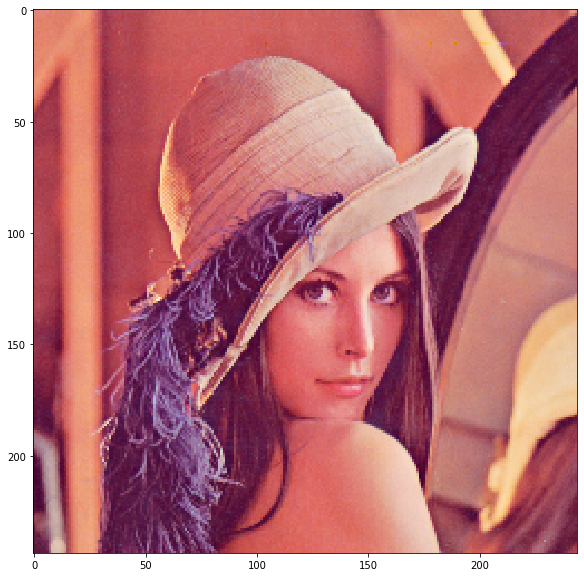

In [65]:
plt.figure(figsize=(12, 10))
plt.imshow(x.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


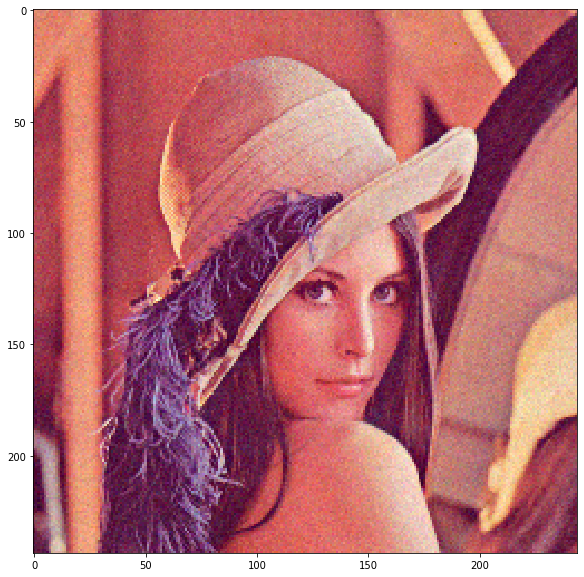

In [68]:
# 添加高斯噪声 sigma^2=10
x_1 = (x.numpy() + np.random.randn(244, 244, 3) * 10) / 255
plt.figure(figsize=(12, 10))                                                                                                                                                                                                                                                                                                                                             
plt.imshow(x_1)

## 过拟合问题

In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
X, y = make_moons(n_samples=N_SAMPLES, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
def make_plot(X, y, title, file_name=None, xx=None, yy=None, preds=None):
    plt.figure(figsize=(10, 8))
    axes = plt.gca()
    xmax, xmin = np.max(X[:, 0]), np.min(X[:, 0])
    ymax, ymin = np.max(X[:, 1]), np.min(X[:, 1])
    axes.set_xlim([xmin, xmax])
    axes.set_ylim([ymin, ymax])
    if (xx is not None and yy is not None and preds is not None):
        plt.contour(xx, yy, preds.reshape(xx.shape), 25, alpha=0.08, cmap=plt.cm.Spectral)
        plt.contourf(xx, yy, preds.reshape(xx.shape), levels=[.5, 1.], cmap='Greys', vmin=0, vmax=.6)
    
    plt.scatter(X[y==0, 0], X[y==0, 1], s=10, cmap=plt.cm.Spectral, marker='s')
    plt.scatter(X[y==1, 0], X[y==1, 1], s=10,cmap=plt.cm.Spectral, marker='o')
    plt.title(title)
    if file_name is not None:
        plt.savefig(file_name)

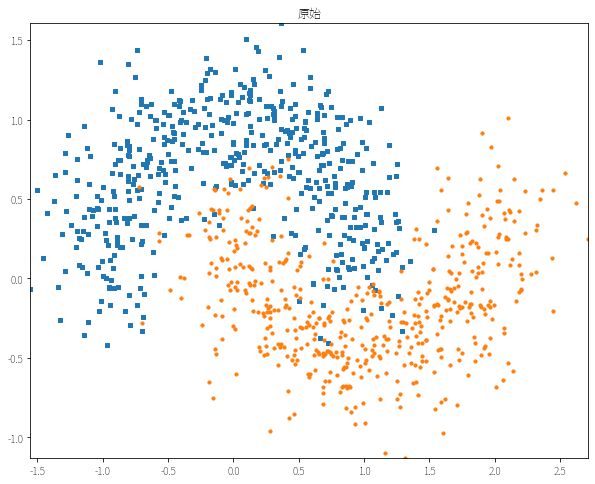

In [8]:
make_plot(X, y, title='原始')

**网络层的影响**

探讨不同的网络深度下的过拟合程度

In [3]:
N_EPOCHS = 20

In [88]:
xx, yy = np.mgrid[-2:3:0.05, -2:2:0.05]
xx.shape, yy.shape

((100, 80), (100, 80))

In [90]:
np.c_[xx.ravel(), yy.ravel()]

array([[-2.  , -2.  ],
       [-2.  , -1.95],
       [-2.  , -1.9 ],
       ...,
       [ 2.95,  1.85],
       [ 2.95,  1.9 ],
       [ 2.95,  1.95]])

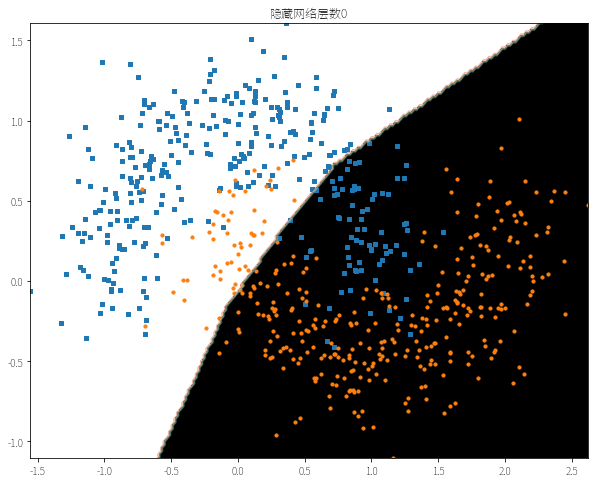

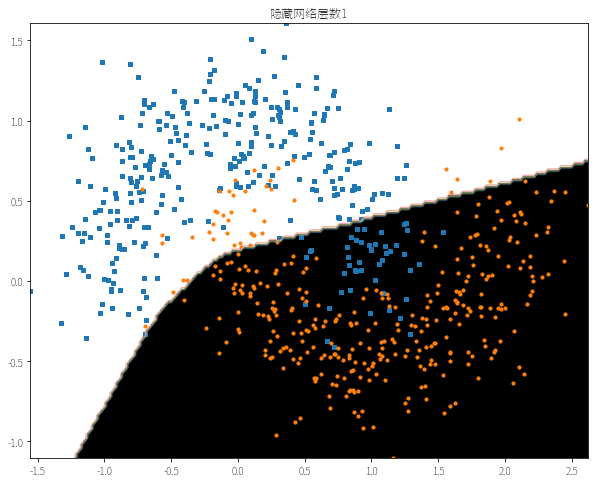

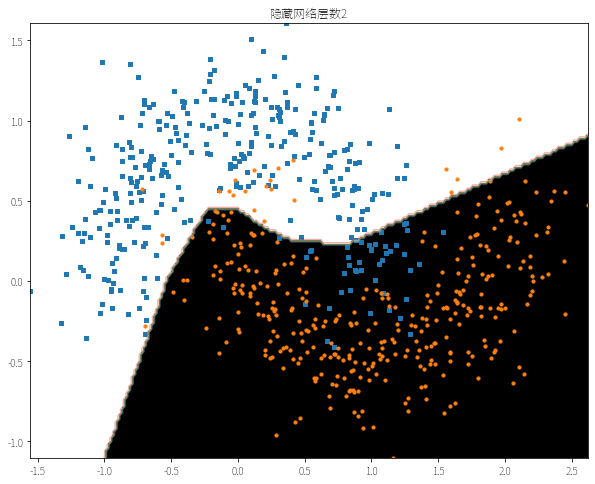

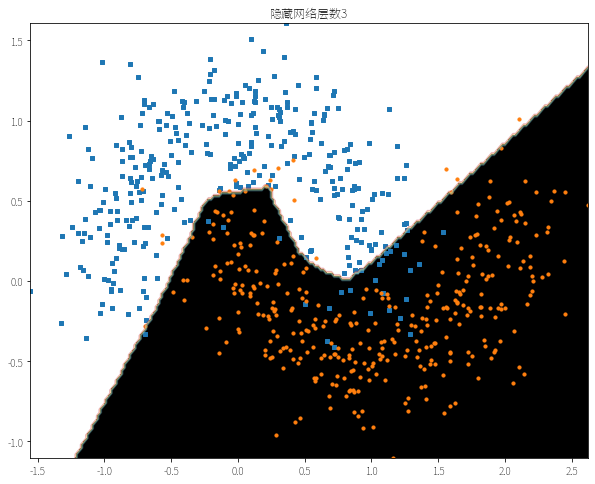

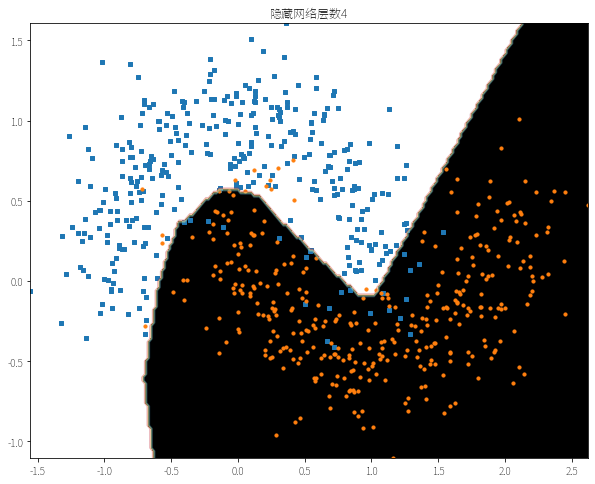

In [9]:
for n in range(5):
    model = Sequential()
    model.add(layers.Dense(8, input_dim=2, activation='relu'))
    for _ in range(n):  # 共 n + 2
        model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    # 模型装配
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # 训练
    history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)
    xx, yy = np.mgrid[-2:3:0.02, -2:2:0.02]
    preds = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])
    name = f"隐藏网络层数{n}"
    make_plot(X_train, y_train, name, name, xx, yy, preds)

**Dropout的影响**